In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import random
import decimal
import operator
import math
%matplotlib inline

In [2]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          if next_next in self.goal_states_seq:
                done=True
          else:
                done=False
          return next_next, self.R[next_next],done
        else:
          if next_state in self.goal_states_seq:
                done=True
          else:
            done=False
          return next_state, self.R[next_state],done

    

CHange start state, p values,wind

In [3]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
#change
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

In [4]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [5]:
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
actions = [UP,DOWN,LEFT,RIGHT]

Function for plots


In [6]:
def plot_Q(Q, message = "Q plot",progress = ""):

    k=len(message)
    plt.figure(figsize=(10,10))
    plt.suptitle(message)
    print(message)
    plt.title(progress)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        return 1 if a == UP else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    #plt.savefig(f"Q_{message}.jpg")
    plt.show()

In [7]:
def plot_state_visits(state_visit_counts,message="State Visit Count Plot",progress=""):
    k=len(message)
    plt.figure(figsize=(10,10))

    plt.suptitle(message)
    plt.title(progress)
    plt.pcolor(state_visit_counts, edgecolors='k', linewidths=2)
    plt.colorbar()
    #plt.savefig(f"State_{message}.jpg")

EPSILON GREEDY AND SOFTMAX ALGORITHMS

In [8]:
from scipy.special import softmax

import random

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon=0.1):
    if not Q[state[0][0], state[0][1]].any() or random.random() < epsilon: # randomly choose based on epsilon
        return random.randint(0, Q.shape[-1] - 1) # return random action
    else:
        return np.argmax(Q[state[0][0], state[0][1]]) # return best action

# Softmax
def choose_action_softmax(Q, state,tau=1):
    Q = Q / tau
    action_probs = softmax(Q[state[0][0], state[0][1]])
    return random.choices(range(len(action_probs)), weights=action_probs)[0] # returns a random action with selection probability

# Example usage:
# action = choose_action_softmax(Q_values, state)


IMPLEMENT SARSA

In [9]:
Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
alpha0 = 0.4
gamma = 0.9
episodes = 5001
epsilon0 = 0.1

In [10]:
print_freq = 100

def sarsa(env, Q,parameter,alpha = alpha0, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    #alpha = alpha0
    count_state_visit_throughout= np.zeros((env.num_rows, env.num_cols))
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        count_state_visit= np.zeros((env.num_rows, env.num_cols))
        state = env.reset()
        state = seq_to_col_row(state,num_cols)
        action = choose_action(Q, state,parameter)
        done = False
        while not done:
            count_state_visit[state[0][0]][state[0][1]]+=1
            state_next, reward,done = env.step(row_col_to_seq(state,num_cols),action)
            state_next=(seq_to_col_row(state_next,num_cols))
            action_next = choose_action(Q, state_next,parameter)

            # TODO: update equation
            Q[state[0][0],state[0][1],action] += alpha*(reward + gamma*(Q[state_next[0][0],state_next[0][1],action_next]) - Q[state[0][0],state[0][1],action])

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next
            if steps > 300:
                break

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
            plot_state_visits(count_state_visit)
        for i in range(len(count_state_visit_throughout)):
            for j in range(len(count_state_visit_throughout[i])):
                count_state_visit_throughout[i][j] += count_state_visit[i][j]


    return Q, episode_rewards, steps_to_completion,  count_state_visit, count_state_visit_throughout

In [11]:
print_freq = 100

def qlearning(env, Q,parameter,alpha = alpha0, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    #alpha = alpha0
    count_state_visit_throughout= np.zeros((env.num_rows, env.num_cols))
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        count_state_visit= np.zeros((env.num_rows, env.num_cols))
        state = env.reset()
        state = seq_to_col_row(state,num_cols)
        action = choose_action(Q, state,parameter)
        done = False
        while not done:
            count_state_visit[state[0][0]][state[0][1]]+=1
            state_next, reward,done = env.step(row_col_to_seq(state,num_cols),action)
            state_next=(seq_to_col_row(state_next,num_cols))
            action_next = choose_action(Q, state_next,parameter)

            # TODO: update equation
            Q[state[0][0], state[0][1], action] += alpha*(reward + gamma*np.max([Q[state_next[0][0], state_next[0][1], action] for action in actions]) - Q[state[0][0], state[0][1], action])

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next
            if steps > 300:
                break

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
            plot_state_visits(count_state_visit)
        for i in range(len(count_state_visit_throughout)):
            for j in range(len(count_state_visit_throughout[i])):
                count_state_visit_throughout[i][j] += count_state_visit[i][j]


    return Q, episode_rewards, steps_to_completion,  count_state_visit, count_state_visit_throughout

In [12]:
def average_over_5_runs_sarsa_epsilon(env,parameter,alpha,gamma):
  num_expts = 5
  reward_avgs, steps_avgs = [0 for i in range(episodes)], [0 for i in range(episodes)]
  rewards_,steps_ = [[] for i in range(episodes)],[[] for i in range(episodes)]
  std_deviation_reward = [0 for i in range(episodes)]
  std_deviation_steps = [0 for i in range(episodes)]
  for i in range(num_expts):
      print("Experiment: %d"%(i+1))
      Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
      rg = np.random.RandomState(i)
      Q_s, reward_s, step_s, state_visit_count,count_throughout= sarsa(env, Q,parameter = parameter, alpha = alpha,  gamma = gamma, plot_heat=False, choose_action= choose_action_epsilon)
    
      
      for ep in range(episodes):
        rewards_[ep].append(reward_s[ep])
        steps_[ep].append(step_s[ep])

  reward_avgs = [x/num_expts for x in reward_avgs]
  steps_avgs = [x/num_expts for x in steps_avgs]
  for i in range(len(std_deviation_reward)):
     mean = sum(rewards_[i]) / len(rewards_[i])
     variance = sum([((x - mean) ** 2) for x in rewards_[i]]) / len(rewards_[i])
     reward_avgs[i] = mean
     std_deviation_reward[i] = math.sqrt(variance)

     mean = sum(steps_[i]) / len(steps_[i])
     variance = sum([((x - mean) ** 2) for x in steps_[i]]) / len(steps_[i])
     steps_avgs[i] = mean
     std_deviation_steps[i] = math.sqrt(variance)


     

  return reward_avgs , steps_avgs, std_deviation_reward,std_deviation_steps


In [13]:
def average_over_5_runs_qlearning_epsilon(env,parameter,alpha,gamma):
  num_expts = 5
  reward_avgs, steps_avgs = [0 for i in range(episodes)], [0 for i in range(episodes)]
  rewards_,steps_ = [[] for i in range(episodes)],[[] for i in range(episodes)]
  std_deviation_reward = [0 for i in range(episodes)]
  std_deviation_steps = [0 for i in range(episodes)]
  for i in range(num_expts):
      print("Experiment: %d"%(i+1))
      Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
      rg = np.random.RandomState(i)
      Q_s, reward_s, step_s, state_visit_count,count_throughout= qlearning(env, Q,parameter = parameter, alpha = alpha,  gamma = gamma, plot_heat=False, choose_action= choose_action_epsilon)
      '''reward_avgs =  [x + y for x, y in zip(reward_s, reward_avgs)]
      steps_avgs =  [x + y for x, y in zip(step_s, steps_avgs)]'''
      
      for ep in range(episodes):
        rewards_[ep].append(reward_s[ep])
        steps_[ep].append(step_s[ep])

  reward_avgs = [x/num_expts for x in reward_avgs]
  steps_avgs = [x/num_expts for x in steps_avgs]
  for i in range(len(std_deviation_reward)):
     mean = sum(rewards_[i]) / len(rewards_[i])
     variance = sum([((x - mean) ** 2) for x in rewards_[i]]) / len(rewards_[i])
     reward_avgs[i] = mean
     std_deviation_reward[i] = math.sqrt(variance)

     mean = sum(steps_[i]) / len(steps_[i])
     variance = sum([((x - mean) ** 2) for x in steps_[i]]) / len(steps_[i])
     steps_avgs[i] = mean
     std_deviation_steps[i] = math.sqrt(variance)


     

  return reward_avgs , steps_avgs, std_deviation_reward,std_deviation_steps


In [14]:
def average_over_5_runs_sarsa_softmax(env,parameter,alpha,gamma):
  num_expts = 5
  reward_avgs, steps_avgs = [0 for i in range(episodes)], [0 for i in range(episodes)]
  rewards_,steps_ = [[] for i in range(episodes)],[[] for i in range(episodes)]
  std_deviation_reward = [0 for i in range(episodes)]
  std_deviation_steps = [0 for i in range(episodes)]
  for i in range(num_expts):
      print("Experiment: %d"%(i+1))
      Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
      rg = np.random.RandomState(i)
      Q_s, reward_s, step_s, state_visit_count,count_throughout= sarsa(env, Q,parameter = parameter, alpha = alpha,  gamma = gamma, plot_heat=False, choose_action= choose_action_softmax)
    
      
      for ep in range(episodes):
        rewards_[ep].append(reward_s[ep])
        steps_[ep].append(step_s[ep])

  reward_avgs = [x/num_expts for x in reward_avgs]
  steps_avgs = [x/num_expts for x in steps_avgs]
  for i in range(len(std_deviation_reward)):
     mean = sum(rewards_[i]) / len(rewards_[i])
     variance = sum([((x - mean) ** 2) for x in rewards_[i]]) / len(rewards_[i])
     reward_avgs[i] = mean
     std_deviation_reward[i] = math.sqrt(variance)

     mean = sum(steps_[i]) / len(steps_[i])
     variance = sum([((x - mean) ** 2) for x in steps_[i]]) / len(steps_[i])
     steps_avgs[i] = mean
     std_deviation_steps[i] = math.sqrt(variance)


     

  return reward_avgs , steps_avgs, std_deviation_reward,std_deviation_steps


In [15]:
def average_over_5_runs_qlearning_softmax(env,parameter,alpha,gamma):
  num_expts = 5
  reward_avgs, steps_avgs = [0 for i in range(episodes)], [0 for i in range(episodes)]
  rewards_,steps_ = [[] for i in range(episodes)],[[] for i in range(episodes)]
  std_deviation_reward = [0 for i in range(episodes)]
  std_deviation_steps = [0 for i in range(episodes)]
  for i in range(num_expts):
      print("Experiment: %d"%(i+1))
      Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
      rg = np.random.RandomState(i)
      Q_s, reward_s, step_s, state_visit_count,count_throughout= qlearning(env, Q,parameter = parameter, alpha = alpha,  gamma = gamma, plot_heat=False, choose_action= choose_action_softmax)
      '''reward_avgs =  [x + y for x, y in zip(reward_s, reward_avgs)]
      steps_avgs =  [x + y for x, y in zip(step_s, steps_avgs)]'''
      
      for ep in range(episodes):
        rewards_[ep].append(reward_s[ep])
        steps_[ep].append(step_s[ep])

  reward_avgs = [x/num_expts for x in reward_avgs]
  steps_avgs = [x/num_expts for x in steps_avgs]
  for i in range(len(std_deviation_reward)):
     mean = sum(rewards_[i]) / len(rewards_[i])
     variance = sum([((x - mean) ** 2) for x in rewards_[i]]) / len(rewards_[i])
     reward_avgs[i] = mean
     std_deviation_reward[i] = math.sqrt(variance)

     mean = sum(steps_[i]) / len(steps_[i])
     variance = sum([((x - mean) ** 2) for x in steps_[i]]) / len(steps_[i])
     steps_avgs[i] = mean
     std_deviation_steps[i] = math.sqrt(variance)


     

  return reward_avgs , steps_avgs, std_deviation_reward,std_deviation_steps


In [16]:
store_dict = {}

change start state, p value and wind

In [17]:
import math

In [18]:
def average_over_5_runs_sarsa_bayeian_epsilon(parameter,alpha,gamma):
  num_expts = 5
  reward_avgs, steps_avgs = [0 for i in range(episodes)], [0 for i in range(episodes)]
  rewards_,steps_ = [[] for i in range(episodes)],[[] for i in range(episodes)]
  std_deviation_reward = [0 for i in range(episodes)]
  std_deviation_steps = [0 for i in range(episodes)]
  for i in range(num_expts):
      print("Experiment: %d"%(i+1))
      Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
      rg = np.random.RandomState(i)
      Q_s, reward_s, step_s, state_visit_count,count_throughtout= sarsa(env, Q,parameter = parameter, alpha = alpha,  gamma = gamma, plot_heat=False, choose_action= choose_action_epsilon)
      '''reward_avgs =  [x + y for x, y in zip(reward_s, reward_avgs)]
      steps_avgs =  [x + y for x, y in zip(step_s, steps_avgs)]'''
      
      for ep in range(episodes):
        rewards_[ep].append(reward_s[ep])
        steps_[ep].append(step_s[ep])

  reward_avgs = [x/num_expts for x in reward_avgs]
  steps_avgs = [x/num_expts for x in steps_avgs]
  for i in range(len(std_deviation_reward)):
     mean = sum(rewards_[i]) / len(rewards_[i])
     variance = sum([((x - mean) ** 2) for x in rewards_[i]]) / len(rewards_[i])
     reward_avgs[i] = mean
     std_deviation_reward[i] = math.sqrt(variance)

     mean = sum(steps_[i]) / len(steps_[i])
     variance = sum([((x - mean) ** 2) for x in steps_[i]]) / len(steps_[i])
     steps_avgs[i] = mean
     std_deviation_steps[i] = math.sqrt(variance)


     

  return reward_avgs , steps_avgs, std_deviation_reward,std_deviation_steps


In [19]:
def average_over_5_runs_sarsa_bayeian_softmax(parameter,alpha,gamma):
  num_expts = 5
  reward_avgs, steps_avgs = [0 for i in range(episodes)], [0 for i in range(episodes)]
  rewards_,steps_ = [[] for i in range(episodes)],[[] for i in range(episodes)]
  std_deviation_reward = [0 for i in range(episodes)]
  std_deviation_steps = [0 for i in range(episodes)]
  for i in range(num_expts):
      print("Experiment: %d"%(i+1))
      Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
      rg = np.random.RandomState(i)
      Q_s, reward_s, step_s, state_visit_count,count_throughtout= sarsa(env, Q,parameter = parameter, alpha = alpha,  gamma = gamma, plot_heat=False, choose_action= choose_action_softmax)
      '''reward_avgs =  [x + y for x, y in zip(reward_s, reward_avgs)]
      steps_avgs =  [x + y for x, y in zip(step_s, steps_avgs)]'''
      
      for ep in range(episodes):
        rewards_[ep].append(reward_s[ep])
        steps_[ep].append(step_s[ep])

  reward_avgs = [x/num_expts for x in reward_avgs]
  steps_avgs = [x/num_expts for x in steps_avgs]
  for i in range(len(std_deviation_reward)):
     mean = sum(rewards_[i]) / len(rewards_[i])
     variance = sum([((x - mean) ** 2) for x in rewards_[i]]) / len(rewards_[i])
     reward_avgs[i] = mean
     std_deviation_reward[i] = math.sqrt(variance)

     mean = sum(steps_[i]) / len(steps_[i])
     variance = sum([((x - mean) ** 2) for x in steps_[i]]) / len(steps_[i])
     steps_avgs[i] = mean
     std_deviation_steps[i] = math.sqrt(variance)


     

  return reward_avgs , steps_avgs, std_deviation_reward,std_deviation_steps


In [20]:
def average_over_5_runs_qlearning_bayeian_epsilon(parameter,alpha,gamma):
  num_expts = 5
  reward_avgs, steps_avgs = [0 for i in range(episodes)], [0 for i in range(episodes)]
  rewards_,steps_ = [[] for i in range(episodes)],[[] for i in range(episodes)]
  std_deviation_reward = [0 for i in range(episodes)]
  std_deviation_steps = [0 for i in range(episodes)]
  for i in range(num_expts):
      print("Experiment: %d"%(i+1))
      Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
      rg = np.random.RandomState(i)
      Q_s, reward_s, step_s, state_visit_count,count_throughout= qlearning(env, Q,parameter = parameter, alpha = alpha,  gamma = gamma, plot_heat=False, choose_action= choose_action_epsilon)
      '''reward_avgs =  [x + y for x, y in zip(reward_s, reward_avgs)]
      steps_avgs =  [x + y for x, y in zip(step_s, steps_avgs)]'''
      
      for ep in range(episodes):
        rewards_[ep].append(reward_s[ep])
        steps_[ep].append(step_s[ep])

  reward_avgs = [x/num_expts for x in reward_avgs]
  steps_avgs = [x/num_expts for x in steps_avgs]
  for i in range(len(std_deviation_reward)):
     mean = sum(rewards_[i]) / len(rewards_[i])
     variance = sum([((x - mean) ** 2) for x in rewards_[i]]) / len(rewards_[i])
     reward_avgs[i] = mean
     std_deviation_reward[i] = math.sqrt(variance)

     mean = sum(steps_[i]) / len(steps_[i])
     variance = sum([((x - mean) ** 2) for x in steps_[i]]) / len(steps_[i])
     steps_avgs[i] = mean
     std_deviation_steps[i] = math.sqrt(variance)


     

  return reward_avgs , steps_avgs, std_deviation_reward,std_deviation_steps


In [21]:
def average_over_5_runs_qlearning_bayeian_softmax(parameter,alpha,gamma):
  num_expts = 5
  reward_avgs, steps_avgs = [0 for i in range(episodes)], [0 for i in range(episodes)]
  rewards_,steps_ = [[] for i in range(episodes)],[[] for i in range(episodes)]
  std_deviation_reward = [0 for i in range(episodes)]
  std_deviation_steps = [0 for i in range(episodes)]
  for i in range(num_expts):
      print("Experiment: %d"%(i+1))
      Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
      rg = np.random.RandomState(i)
      Q_s, reward_s, step_s, state_visit_count,count_throughout= qlearning(env, Q,parameter = parameter, alpha = alpha,  gamma = gamma, plot_heat=False, choose_action= choose_action_softmax)
      '''reward_avgs =  [x + y for x, y in zip(reward_s, reward_avgs)]
      steps_avgs =  [x + y for x, y in zip(step_s, steps_avgs)]'''
      
      for ep in range(episodes):
        rewards_[ep].append(reward_s[ep])
        steps_[ep].append(step_s[ep])

  reward_avgs = [x/num_expts for x in reward_avgs]
  steps_avgs = [x/num_expts for x in steps_avgs]
  for i in range(len(std_deviation_reward)):
     mean = sum(rewards_[i]) / len(rewards_[i])
     variance = sum([((x - mean) ** 2) for x in rewards_[i]]) / len(rewards_[i])
     reward_avgs[i] = mean
     std_deviation_reward[i] = math.sqrt(variance)

     mean = sum(steps_[i]) / len(steps_[i])
     variance = sum([((x - mean) ** 2) for x in steps_[i]]) / len(steps_[i])
     steps_avgs[i] = mean
     std_deviation_steps[i] = math.sqrt(variance)


     

  return reward_avgs , steps_avgs, std_deviation_reward,std_deviation_steps


In [22]:
def average_over_5_runs_sarsa_softmax(env,parameter,alpha,gamma):
  num_expts = 5
  reward_avgs, steps_avgs = [0 for i in range(episodes)], [0 for i in range(episodes)]
  rewards_,steps_ = [[] for i in range(episodes)],[[] for i in range(episodes)]
  std_deviation_reward = [0 for i in range(episodes)]
  std_deviation_steps = [0 for i in range(episodes)]
  for i in range(num_expts):
      print("Experiment: %d"%(i+1))
      Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
      rg = np.random.RandomState(i)
      Q_s, reward_s, step_s, state_visit_count,count_throughout= sarsa(env, Q,parameter = parameter, alpha = alpha,  gamma = gamma, plot_heat=False, choose_action= choose_action_softmax)
    
      
      for ep in range(episodes):
        rewards_[ep].append(reward_s[ep])
        steps_[ep].append(step_s[ep])

  reward_avgs = [x/num_expts for x in reward_avgs]
  steps_avgs = [x/num_expts for x in steps_avgs]
  for i in range(len(std_deviation_reward)):
     mean = sum(rewards_[i]) / len(rewards_[i])
     variance = sum([((x - mean) ** 2) for x in rewards_[i]]) / len(rewards_[i])
     reward_avgs[i] = mean
     std_deviation_reward[i] = math.sqrt(variance)

     mean = sum(steps_[i]) / len(steps_[i])
     variance = sum([((x - mean) ** 2) for x in steps_[i]]) / len(steps_[i])
     steps_avgs[i] = mean
     std_deviation_steps[i] = math.sqrt(variance)


     

  return reward_avgs , steps_avgs, std_deviation_reward,std_deviation_steps


In [23]:
def average_over_5_runs_qlearning_epsilon(env,parameter,alpha,gamma):
  num_expts = 5
  reward_avgs, steps_avgs = [0 for i in range(episodes)], [0 for i in range(episodes)]
  rewards_,steps_ = [[] for i in range(episodes)],[[] for i in range(episodes)]
  std_deviation_reward = [0 for i in range(episodes)]
  std_deviation_steps = [0 for i in range(episodes)]
  for i in range(num_expts):
      print("Experiment: %d"%(i+1))
      Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
      rg = np.random.RandomState(i)
      Q_s, reward_s, step_s, state_visit_count,count_throughout= qlearning(env, Q,parameter = parameter, alpha = alpha,  gamma = gamma, plot_heat=False, choose_action= choose_action_epsilon)
    
      
      for ep in range(episodes):
        rewards_[ep].append(reward_s[ep])
        steps_[ep].append(step_s[ep])

  reward_avgs = [x/num_expts for x in reward_avgs]
  steps_avgs = [x/num_expts for x in steps_avgs]
  for i in range(len(std_deviation_reward)):
     mean = sum(rewards_[i]) / len(rewards_[i])
     variance = sum([((x - mean) ** 2) for x in rewards_[i]]) / len(rewards_[i])
     reward_avgs[i] = mean
     std_deviation_reward[i] = math.sqrt(variance)

     mean = sum(steps_[i]) / len(steps_[i])
     variance = sum([((x - mean) ** 2) for x in steps_[i]]) / len(steps_[i])
     steps_avgs[i] = mean
     std_deviation_steps[i] = math.sqrt(variance)


     

  return reward_avgs , steps_avgs, std_deviation_reward,std_deviation_steps


In [24]:
def average_over_5_runs_qlearning_softmax(env,parameter,alpha,gamma):
  num_expts = 5
  reward_avgs, steps_avgs = [0 for i in range(episodes)], [0 for i in range(episodes)]
  rewards_,steps_ = [[] for i in range(episodes)],[[] for i in range(episodes)]
  std_deviation_reward = [0 for i in range(episodes)]
  std_deviation_steps = [0 for i in range(episodes)]
  for i in range(num_expts):
      print("Experiment: %d"%(i+1))
      Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
      rg = np.random.RandomState(i)
      Q_s, reward_s, step_s, state_visit_count,count_throughout= qlearning(env, Q,parameter = parameter, alpha = alpha,  gamma = gamma, plot_heat=False, choose_action= choose_action_softmax)
    
      
      for ep in range(episodes):
        rewards_[ep].append(reward_s[ep])
        steps_[ep].append(step_s[ep])

  reward_avgs = [x/num_expts for x in reward_avgs]
  steps_avgs = [x/num_expts for x in steps_avgs]
  for i in range(len(std_deviation_reward)):
     mean = sum(rewards_[i]) / len(rewards_[i])
     variance = sum([((x - mean) ** 2) for x in rewards_[i]]) / len(rewards_[i])
     reward_avgs[i] = mean
     std_deviation_reward[i] = math.sqrt(variance)

     mean = sum(steps_[i]) / len(steps_[i])
     variance = sum([((x - mean) ** 2) for x in steps_[i]]) / len(steps_[i])
     steps_avgs[i] = mean
     std_deviation_steps[i] = math.sqrt(variance)


     

  return reward_avgs , steps_avgs, std_deviation_reward,std_deviation_steps


In [25]:
param_space = {
    'parameter': (0.1,1000),
    'alpha': (0.1, 0.999),
    'gamma': (0.6, 0.999),
}

change the max function to what u want to 

In [26]:
def function_to_maximize(parameter,alpha,gamma):
    res = average_over_5_runs_sarsa_bayeian_softmax(parameter,alpha,gamma)
    #change 
    return np.mean(res[0])

In [27]:
from bayes_opt import BayesianOptimization

In [28]:
optimizer = BayesianOptimization(
    f=function_to_maximize,
    pbounds=param_space,
    random_state=1,
)

In [29]:
optimizer.maximize(
    init_points=9,
    n_iter=20,
)

|   iter    |  target   |   alpha   |   gamma   | parameter |
-------------------------------------------------------------
Experiment: 1


  1%|          | 41/5001 [00:00<01:03, 77.87it/s]

100%|██████████| 5001/5001 [00:27<00:00, 178.91it/s]


Experiment: 2


100%|██████████| 5001/5001 [00:42<00:00, 118.28it/s]


Experiment: 3


100%|██████████| 5001/5001 [00:46<00:00, 108.35it/s]


Experiment: 4


100%|██████████| 5001/5001 [00:58<00:00, 86.07it/s] 


Experiment: 5


100%|██████████| 5001/5001 [00:57<00:00, 87.42it/s] 


| 1         | -30.21    | 0.4749    | 0.8874    | 0.2144    |
Experiment: 1


100%|██████████| 5001/5001 [05:42<00:00, 14.59it/s]


Experiment: 2


100%|██████████| 5001/5001 [05:33<00:00, 15.00it/s]


Experiment: 3


100%|██████████| 5001/5001 [05:23<00:00, 15.45it/s]


Experiment: 4


100%|██████████| 5001/5001 [05:19<00:00, 15.63it/s]


Experiment: 5


100%|██████████| 5001/5001 [05:24<00:00, 15.42it/s]


| 2         | -615.8    | 0.3718    | 0.6586    | 92.43     |
Experiment: 1


100%|██████████| 5001/5001 [05:26<00:00, 15.32it/s]


Experiment: 2


100%|██████████| 5001/5001 [05:23<00:00, 15.44it/s]


Experiment: 3


100%|██████████| 5001/5001 [05:33<00:00, 15.02it/s]


Experiment: 4


100%|██████████| 5001/5001 [05:21<00:00, 15.54it/s]


Experiment: 5


100%|██████████| 5001/5001 [05:22<00:00, 15.52it/s]


| 3         | -734.9    | 0.2674    | 0.7379    | 396.8     |
Experiment: 1


100%|██████████| 5001/5001 [05:33<00:00, 14.98it/s]


Experiment: 2


100%|██████████| 5001/5001 [05:31<00:00, 15.07it/s]


Experiment: 3


100%|██████████| 5001/5001 [05:30<00:00, 15.13it/s]


Experiment: 4


100%|██████████| 5001/5001 [05:28<00:00, 15.24it/s]


Experiment: 5


100%|██████████| 5001/5001 [05:34<00:00, 14.95it/s]


| 4         | -759.3    | 0.5844    | 0.7673    | 685.3     |
Experiment: 1


100%|██████████| 5001/5001 [04:37<00:00, 18.01it/s]


Experiment: 2


100%|██████████| 5001/5001 [04:39<00:00, 17.90it/s]


Experiment: 3


100%|██████████| 5001/5001 [04:30<00:00, 18.49it/s]


Experiment: 4


100%|██████████| 5001/5001 [04:29<00:00, 18.59it/s]


Experiment: 5


100%|██████████| 5001/5001 [04:33<00:00, 18.29it/s]


| 5         | -359.7    | 0.2838    | 0.9504    | 27.48     |
Experiment: 1


100%|██████████| 5001/5001 [05:30<00:00, 15.15it/s]


Experiment: 2


100%|██████████| 5001/5001 [05:34<00:00, 14.94it/s]


Experiment: 3


100%|██████████| 5001/5001 [05:25<00:00, 15.38it/s]


Experiment: 4


100%|██████████| 5001/5001 [05:33<00:00, 15.01it/s]


Experiment: 5


100%|██████████| 5001/5001 [05:31<00:00, 15.08it/s]


| 6         | -748.5    | 0.7028    | 0.7665    | 558.7     |
Experiment: 1


100%|██████████| 5001/5001 [05:28<00:00, 15.23it/s]


Experiment: 2


100%|██████████| 5001/5001 [05:06<00:00, 16.31it/s]


Experiment: 3


100%|██████████| 5001/5001 [05:05<00:00, 16.37it/s]


Experiment: 4


100%|██████████| 5001/5001 [04:20<00:00, 19.23it/s]


Experiment: 5


100%|██████████| 5001/5001 [04:03<00:00, 20.57it/s]


| 7         | -763.6    | 0.2262    | 0.679     | 800.8     |
Experiment: 1


100%|██████████| 5001/5001 [04:00<00:00, 20.75it/s]


Experiment: 2


100%|██████████| 5001/5001 [03:59<00:00, 20.84it/s]


Experiment: 3


100%|██████████| 5001/5001 [04:03<00:00, 20.57it/s]


Experiment: 4


100%|██████████| 5001/5001 [04:03<00:00, 20.56it/s]


Experiment: 5


100%|██████████| 5001/5001 [04:04<00:00, 20.42it/s]


| 8         | -755.0    | 0.9705    | 0.7251    | 692.4     |
Experiment: 1


100%|██████████| 5001/5001 [03:28<00:00, 23.93it/s]


Experiment: 2


100%|██████████| 5001/5001 [03:05<00:00, 26.99it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:53<00:00, 28.87it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:54<00:00, 28.68it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:53<00:00, 28.74it/s]


| 9         | -477.9    | 0.8879    | 0.9569    | 85.14     |
Experiment: 1


100%|██████████| 5001/5001 [01:15<00:00, 66.60it/s] 


Experiment: 2


100%|██████████| 5001/5001 [01:21<00:00, 61.33it/s]


Experiment: 3


100%|██████████| 5001/5001 [01:20<00:00, 62.25it/s] 


Experiment: 4


100%|██████████| 5001/5001 [01:24<00:00, 59.24it/s]


Experiment: 5


100%|██████████| 5001/5001 [01:16<00:00, 65.27it/s] 


| 10        | -111.4    | 0.7224    | 0.8823    | 0.9159    |
Experiment: 1


100%|██████████| 5001/5001 [02:53<00:00, 28.76it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:54<00:00, 28.60it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:58<00:00, 28.09it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:55<00:00, 28.47it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:54<00:00, 28.64it/s]


| 11        | -352.8    | 0.6909    | 0.6756    | 21.73     |
Experiment: 1


100%|██████████| 5001/5001 [01:45<00:00, 47.46it/s]


Experiment: 2


100%|██████████| 5001/5001 [01:46<00:00, 47.18it/s]


Experiment: 3


100%|██████████| 5001/5001 [01:45<00:00, 47.25it/s]


Experiment: 4


100%|██████████| 5001/5001 [01:46<00:00, 46.80it/s]


Experiment: 5


100%|██████████| 5001/5001 [01:44<00:00, 47.83it/s]


| 12        | -195.4    | 0.1854    | 0.9828    | 14.69     |
Experiment: 1


100%|██████████| 5001/5001 [02:44<00:00, 30.41it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:43<00:00, 30.59it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:46<00:00, 29.95it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:44<00:00, 30.38it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:45<00:00, 30.29it/s]


| 13        | -301.5    | 0.1439    | 0.7499    | 9.693     |
Experiment: 1


100%|██████████| 5001/5001 [02:56<00:00, 28.27it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:56<00:00, 28.40it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:55<00:00, 28.48it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:52<00:00, 28.99it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:52<00:00, 29.00it/s]


| 14        | -430.2    | 0.6289    | 0.8516    | 38.05     |
Experiment: 1


100%|██████████| 5001/5001 [01:59<00:00, 41.87it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:00<00:00, 41.65it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:01<00:00, 41.09it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:01<00:00, 41.26it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:01<00:00, 41.29it/s]


| 15        | -302.8    | 0.1       | 0.999     | 51.68     |
Experiment: 1


100%|██████████| 5001/5001 [02:48<00:00, 29.77it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:51<00:00, 29.10it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:51<00:00, 29.09it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:48<00:00, 29.64it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:51<00:00, 29.17it/s]


| 16        | -509.8    | 0.5508    | 0.8475    | 59.81     |
Experiment: 1


100%|██████████| 5001/5001 [02:44<00:00, 30.39it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:47<00:00, 29.83it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:41<00:00, 30.99it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:46<00:00, 30.06it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:42<00:00, 30.84it/s]


| 17        | -389.6    | 0.9072    | 0.8673    | 45.6      |
Experiment: 1


100%|██████████| 5001/5001 [02:58<00:00, 28.03it/s]


Experiment: 2


100%|██████████| 5001/5001 [03:00<00:00, 27.64it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:57<00:00, 28.15it/s]


Experiment: 4


100%|██████████| 5001/5001 [03:00<00:00, 27.71it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:55<00:00, 28.43it/s]


| 18        | -766.3    | 0.1898    | 0.6271    | 942.1     |
Experiment: 1


100%|██████████| 5001/5001 [02:47<00:00, 29.88it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:43<00:00, 30.63it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:42<00:00, 30.72it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:43<00:00, 30.61it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:43<00:00, 30.63it/s]


| 19        | -668.3    | 0.898     | 0.872     | 211.8     |
Experiment: 1


100%|██████████| 5001/5001 [02:36<00:00, 31.89it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:37<00:00, 31.75it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:37<00:00, 31.74it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:35<00:00, 32.08it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:32<00:00, 32.79it/s]


| 20        | -658.4    | 0.4046    | 0.9854    | 304.2     |
Experiment: 1


100%|██████████| 5001/5001 [02:34<00:00, 32.29it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:36<00:00, 32.05it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:32<00:00, 32.69it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:32<00:00, 32.84it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:32<00:00, 32.79it/s]


| 21        | -698.0    | 0.22      | 0.9865    | 477.8     |
Experiment: 1


100%|██████████| 5001/5001 [02:37<00:00, 31.83it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:37<00:00, 31.74it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:36<00:00, 31.97it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:36<00:00, 31.93it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:37<00:00, 31.73it/s]


| 22        | -765.4    | 0.1544    | 0.8181    | 871.2     |
Experiment: 1


100%|██████████| 5001/5001 [02:33<00:00, 32.57it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:32<00:00, 32.76it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:34<00:00, 32.47it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:33<00:00, 32.59it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:33<00:00, 32.58it/s]


| 23        | -578.6    | 0.9409    | 0.6051    | 74.28     |
Experiment: 1


100%|██████████| 5001/5001 [02:35<00:00, 32.11it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:37<00:00, 31.74it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:35<00:00, 32.13it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:36<00:00, 31.89it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:36<00:00, 32.04it/s]


| 24        | -742.9    | 0.1574    | 0.8507    | 622.2     |
Experiment: 1


100%|██████████| 5001/5001 [02:33<00:00, 32.55it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:34<00:00, 32.37it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:34<00:00, 32.32it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:34<00:00, 32.30it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:35<00:00, 32.20it/s]


| 25        | -659.2    | 0.669     | 0.7477    | 151.9     |
Experiment: 1


100%|██████████| 5001/5001 [02:23<00:00, 34.84it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:24<00:00, 34.67it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:24<00:00, 34.57it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:22<00:00, 35.19it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:22<00:00, 35.18it/s]


| 26        | -232.3    | 0.999     | 0.6       | 0.1       |
Experiment: 1


100%|██████████| 5001/5001 [01:47<00:00, 46.60it/s]


Experiment: 2


100%|██████████| 5001/5001 [01:45<00:00, 47.56it/s]


Experiment: 3


100%|██████████| 5001/5001 [01:47<00:00, 46.58it/s]


Experiment: 4


100%|██████████| 5001/5001 [01:46<00:00, 47.07it/s]


Experiment: 5


100%|██████████| 5001/5001 [01:46<00:00, 46.84it/s]


| 27        | -189.1    | 0.1139    | 0.6776    | 1.069     |
Experiment: 1


100%|██████████| 5001/5001 [02:17<00:00, 36.45it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:17<00:00, 36.25it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:12<00:00, 37.65it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:15<00:00, 37.03it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:13<00:00, 37.46it/s]


| 28        | -261.8    | 0.6798    | 0.7935    | 13.38     |
Experiment: 1


100%|██████████| 5001/5001 [02:05<00:00, 39.88it/s]


Experiment: 2


100%|██████████| 5001/5001 [02:09<00:00, 38.54it/s]


Experiment: 3


100%|██████████| 5001/5001 [02:06<00:00, 39.53it/s]


Experiment: 4


100%|██████████| 5001/5001 [02:06<00:00, 39.65it/s]


Experiment: 5


100%|██████████| 5001/5001 [02:04<00:00, 40.20it/s]

| 29        | -248.5    | 0.8811    | 0.9098    | 15.96     |


In [30]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': -30.208638272345528, 'params': {'alpha': 0.47490278222761406, 'gamma': 0.8874094728834211, 'parameter': 0.21436337986315215}}
Iteration 1: 
	{'target': -615.7604879024195, 'params': {'alpha': 0.3717969827960239, 'gamma': 0.6585556004360281, 'parameter': 92.4293609093209}}
Iteration 2: 
	{'target': -734.8847830433913, 'params': {'alpha': 0.2674479300285262, 'gamma': 0.737878730090176, 'parameter': 396.8277974832469}}
Iteration 3: 
	{'target': -759.3364527094581, 'params': {'alpha': 0.5843962438690179, 'gamma': 0.7672586112469146, 'parameter': 685.2509784467198}}
Iteration 4: 
	{'target': -359.66890621875626, 'params': {'alpha': 0.28380257250863417, 'gamma': 0.9503688571199872, 'parameter': 27.484854438606373}}
Iteration 5: 
	{'target': -748.5108178364327, 'params': {'alpha': 0.7027502916503836, 'gamma': 0.7665046161444836, 'parameter': 558.7339594629071}}
Iteration 6: 
	{'target': -763.6010397920415, 'params': {'alpha': 0.22620785779711516, 'gamma': 0.679042494

In [31]:
print(optimizer.max)

{'target': -30.208638272345528, 'params': {'alpha': 0.47490278222761406, 'gamma': 0.8874094728834211, 'parameter': 0.21436337986315215}}


change here

In [32]:
res = average_over_5_runs_sarsa_bayeian_softmax(optimizer.max["params"]["parameter"], optimizer.max["params"]["alpha"],optimizer.max["params"]["gamma"])
#change
print(np.mean(res[0]))

Experiment: 1


100%|██████████| 5001/5001 [00:26<00:00, 185.30it/s]


Experiment: 2


100%|██████████| 5001/5001 [00:27<00:00, 179.47it/s]


Experiment: 3


100%|██████████| 5001/5001 [00:25<00:00, 194.89it/s]


Experiment: 4


100%|██████████| 5001/5001 [00:21<00:00, 230.90it/s]


Experiment: 5


100%|██████████| 5001/5001 [00:31<00:00, 160.23it/s]

-31.577644471105778


change

In [33]:
reward_avgs , steps_avgs,reward_std,steps_std =average_over_5_runs_sarsa_softmax(env,optimizer.max["params"]["parameter"], optimizer.max["params"]["alpha"],optimizer.max["params"]["gamma"])
#change

Experiment: 1


100%|██████████| 5001/5001 [00:25<00:00, 196.17it/s]


Experiment: 2


100%|██████████| 5001/5001 [00:21<00:00, 232.02it/s]


Experiment: 3


100%|██████████| 5001/5001 [00:20<00:00, 248.89it/s]


Experiment: 4


100%|██████████| 5001/5001 [00:22<00:00, 218.17it/s]


Experiment: 5


100%|██████████| 5001/5001 [00:22<00:00, 222.00it/s]


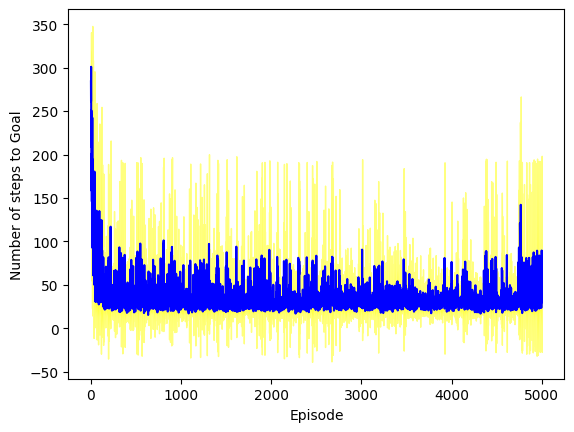

<Figure size 15000x1500 with 0 Axes>

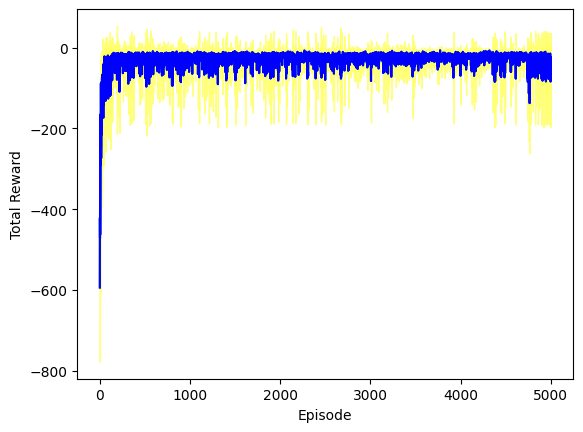

<Figure size 1500x1500 with 0 Axes>

In [34]:
plt.figure()
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
episode_count = np.arange(0, 5001)
plt.plot(episode_count, steps_avgs,color="blue")
lower_steps = [steps_avgs[i] - steps_std[i] for i in range(len(episode_count))]
upper_steps = [steps_avgs[i] + steps_std[i] for i in range(len(episode_count))]
plt.fill_between(episode_count, lower_steps, upper_steps,color='yellow', alpha=0.5, label='± 1 Std Dev')
plt.figure(figsize=(150, 15))
plt.show()

plt.figure()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(episode_count, reward_avgs)
lower_steps = [reward_avgs[i] - reward_std[i] for i in range(len(episode_count))]
upper_steps = [reward_avgs[i] + reward_std[i] for i in range(len(episode_count))]

plt.plot(episode_count, reward_avgs,color = "blue")
plt.fill_between(episode_count, lower_steps, upper_steps,color='yellow', alpha=0.5, label='± 1 Std Dev')
plt.figure(figsize=(15, 15))
plt.show()

In [35]:
Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))

change

Episode 5000: Reward: -25.171717, Steps: 34.25, Qmax: 10.00, Qmin: -52.36


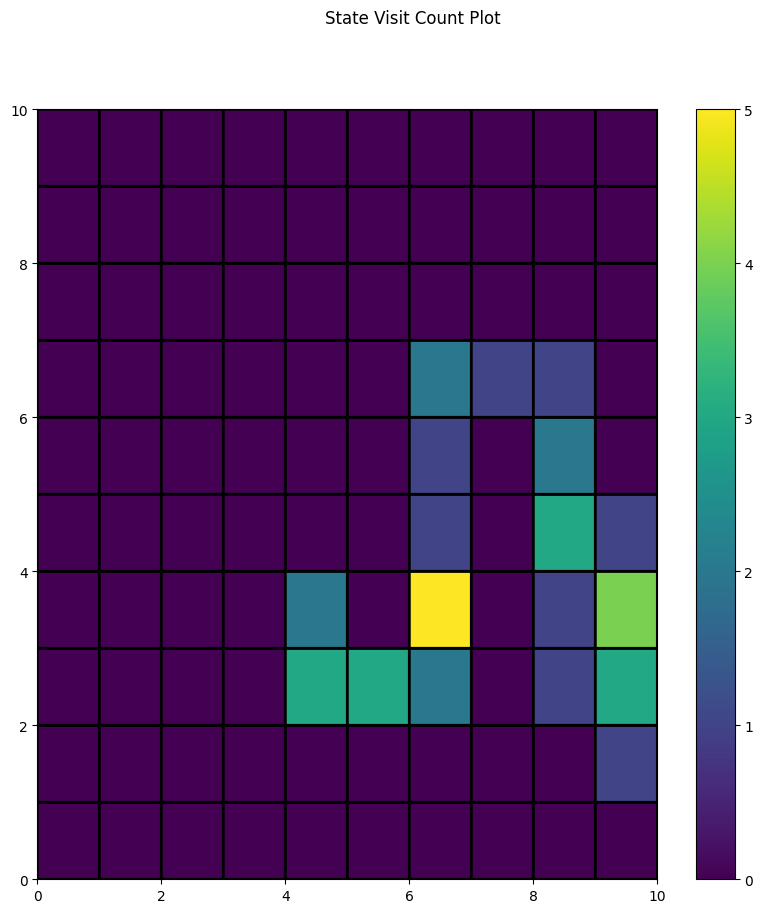

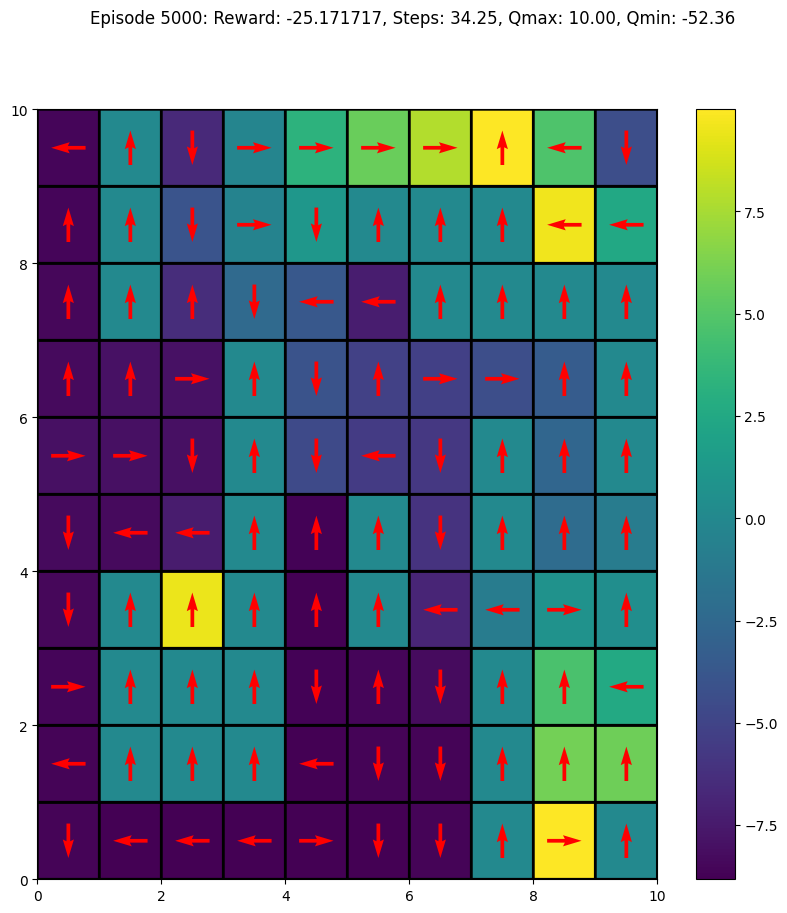

100%|██████████| 5001/5001 [00:35<00:00, 140.17it/s]


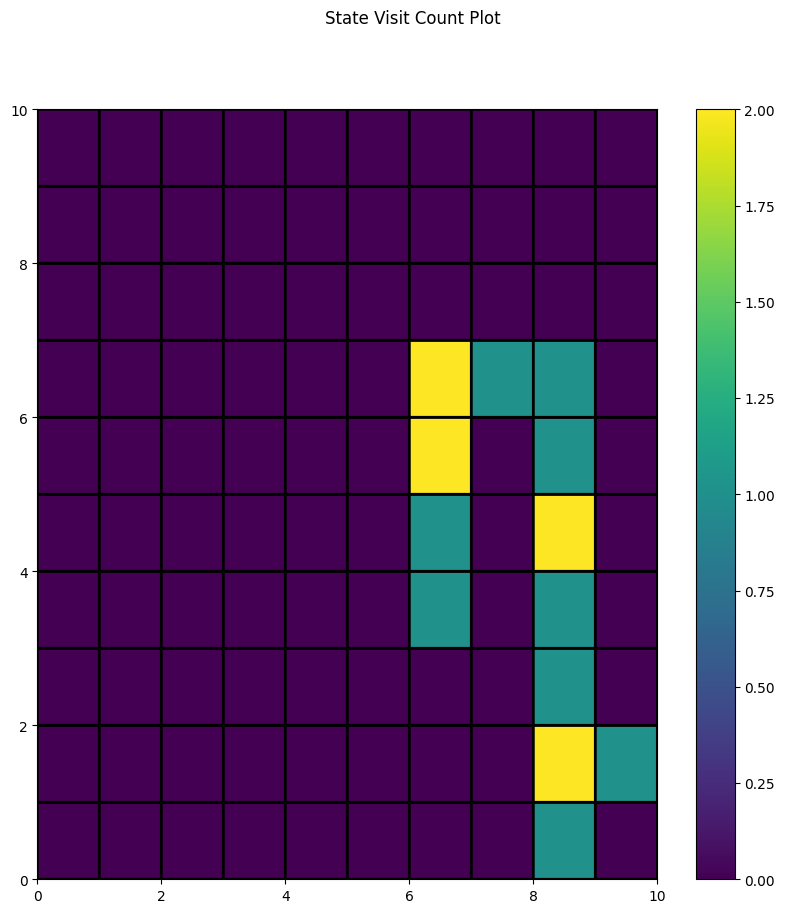

In [36]:
Q, rewards, step,state_visit_count,count_throughout = sarsa(env, Q,alpha = optimizer.max["params"]["alpha"], parameter = optimizer.max["params"]["parameter"], gamma = optimizer.max["params"]["gamma"], plot_heat=True, choose_action= choose_action_softmax)
#change

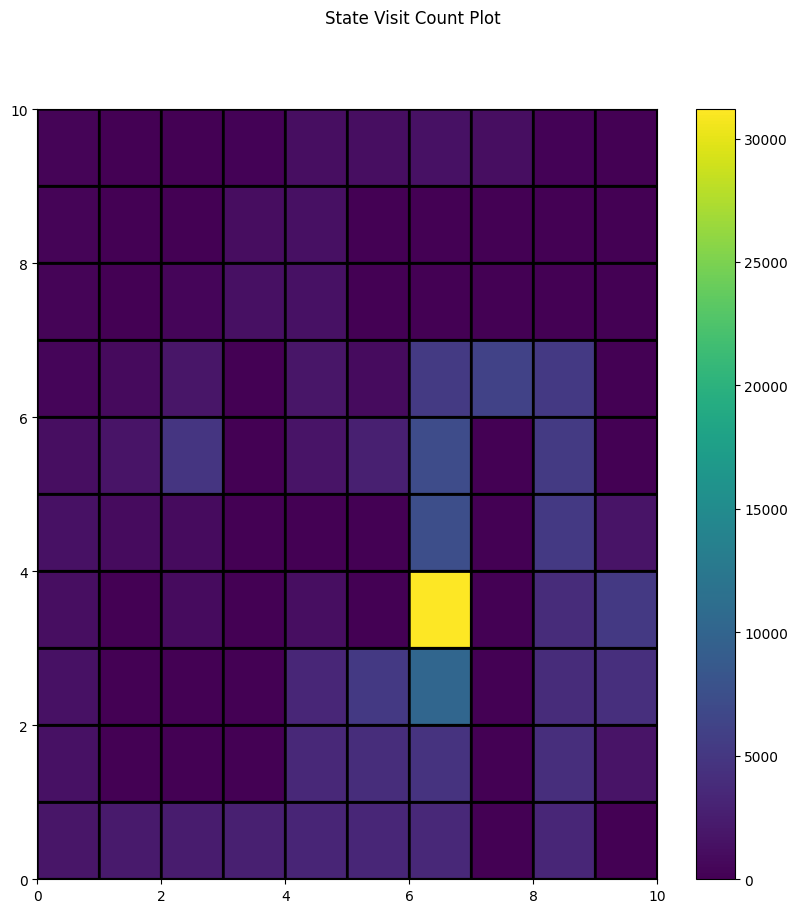

In [37]:
plot_state_visits(count_throughout)